In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
sys.path.append("../")

from src.data.common import DownloadedRepositories, load_repositories_json
from src.data.sharings import find_most_recent_commit_sharings, find_most_recent_pr_sharings, find_most_recent_issue_sharings
from src.utils.compare import *

from pathlib import Path

import json
import tqdm

import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

# Definitions and declarations

In [3]:
repos = load_repositories_json(Path('../data/repositories_download_status.json'))

Loading info about cloned repos from '../data/repositories_download_status.json'...


In [5]:
# information about example repository
repos['sqlalchemy/sqlalchemy']

{'project': 'sqlalchemy_sqlalchemy',
 'repository': 'sqlalchemy/sqlalchemy',
 'repository_url': 'https://github.com/sqlalchemy/sqlalchemy.git',
 'repository_path': '/mnt/data/MSR_Challenge_2024/repositories/sqlalchemy_sqlalchemy'}

In [7]:
dataset_dir = '../data/external/DevGPT'
dataset_dir

'../data/external/DevGPT'

# Commit sharings

In [15]:
commit_sharings_path = find_most_recent_commit_sharings(Path(dataset_dir), verbose=True)
with open(commit_sharings_path) as f:
    commit_data = json.load(f)

Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


In [62]:
# all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'))


# # get url
# diffs = {}
# bad_url = []
# for source in tqdm.tqdm(data['Sources']):

#     try:
#         R = source['RepoName']
#         S  = source['Sha']
#         the_repo = all_repos.repo(R)
#         curr_diff = the_repo.unidiff(S) 
#         diffs[(R,S)] = curr_diff
#     except:
#         bad_url.append((R,S))

In [17]:
def run_joblib(source, conv, compare):
    
    if 'Conversations' not in conv:
        return None, {}
    
    all_repos = DownloadedRepositories(Path('../data/repositories_download_status.json'), verbose=False)

    R = source['RepoName']
    S = source['Sha']
    U = source['URL']
    curr_diff = None
    try:
        the_repo = all_repos.repo(R)
        curr_diff = the_repo.unidiff(S) 
    except:
        pass
    
    if curr_diff:
        return U, diff_to_conversation(curr_diff, conv, compare=compare)
    
    return U, {}

In [64]:
#ret = Parallel(n_jobs=-1)(delayed(run_joblib)(source, conv, compare=CompareLines) for source in tqdm.tqdm(data['Sources']) for conv in source['ChatgptSharing'])


In [65]:
# for source in tqdm.tqdm(data['Sources']):
#     for conv in source['ChatgptSharing']:
#         print(run_joblib(conv))
#         break

In [18]:
def plot_ret(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['coverage'], 'all': r['ALL']['all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()
    

In [19]:
ret_fragments = Parallel(n_jobs=1000)(
    delayed(run_joblib)(source, conv, compare=CompareFragments) 
    for source in tqdm.tqdm(commit_data['Sources']) 
    for conv in source['ChatgptSharing'])


100%|███████████████████████████████████████████████████████| 694/694 [00:00<00:00, 86616.88it/s]
Process LokyProcess-1755:
Process LokyProcess-1776:
Process LokyProcess-1738:
Process LokyProcess-1752:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jnareb/MSR_Challenge_2024/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 450, in _process_worker
    is_clean = worker_exit_lock.acquire(True, timeout=30)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108

KeyboardInterrupt: 

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

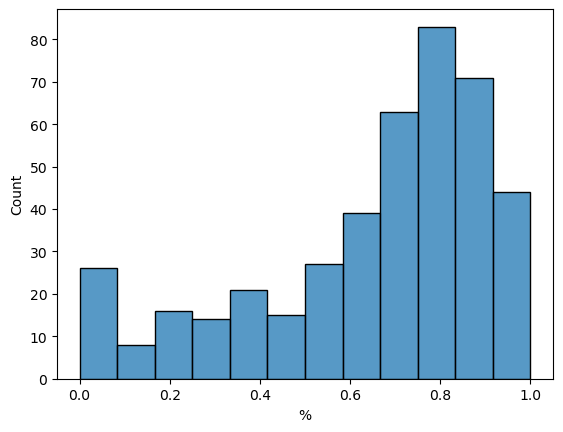

In [68]:
plot_ret(ret_fragments)

In [57]:
def plot_ret_pre(ret):
    df = []
    for rl in ret:
        if not isinstance(rl, tuple):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({'cov' : r['ALL']['preimage_coverage'], 'all': r['ALL']['preimage_all']})
    df = pd.DataFrame(df)
    df['%'] = df['cov']/df['all']
    sns.histplot(df, x='%')
    plt.show()

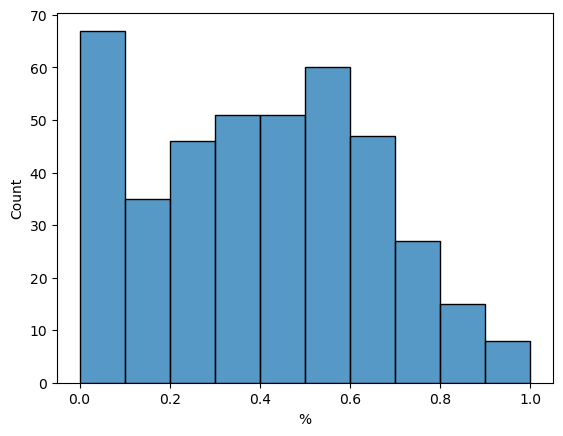

In [69]:
plot_ret_pre(ret_fragments)

In [98]:
with open("./matching_lines.json") as f:
    commits = json.load(f)
    
#commits

In [151]:
def ret_to_df(ret, name):
    df = []
    for rl in ret:
        if not (isinstance(rl, list) or isinstance(rl, tuple)):
            continue
        
        r = rl[1]
        if 'ALL' in r:
            df.append({ 'id': rl[0],
                'PR' : r['ALL']['preimage_coverage'],
                       'PS' : r['ALL']['coverage'],
                       'all': r['ALL']['preimage_all'] + r['ALL']['all'],
                       'PR_all' : r['ALL']['preimage_all'],
                       'PS_all' : r['ALL']['all']
                      }
                     )
    df = pd.DataFrame(df)
    #display(df)
    
    df['postimage/all [%]'] = df['PS']/df['all']
    df['preimage /all [%]'] = df['PR']/df['all']
    df['name'] = name
    
    return df
    

def plot_ret_all(ret_dict, fname="distribution.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    
    df = pd.concat(dfs, keys=ret_dict.keys())
    
    # Show the joint distribution using kernel density estimation
    g = sns.jointplot(
        data=df,
        x="postimage/all [%]", y="preimage /all [%]", hue = 'name',
        kind="kde",
    )
    plt.savefig(fname)
    plt.show()

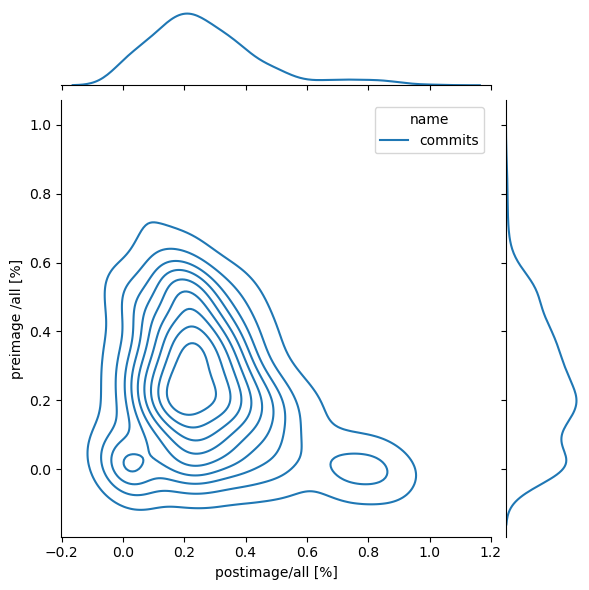

In [79]:
plot_ret_all({'commits':commits})

# PR sharings

In [12]:
pr_sharings_path = find_most_recent_commit_sharings(Path(dataset_dir), verbose=True)
print(f"Found '{pr_sharings_path}'")

with open(pr_sharings_path) as f:
    pr_data = json.load(f)

Latest snapshot is '../data/external/DevGPT/snapshot_20231012'
Found sharings for ['commit', 'discussion', 'file', 'hn', 'issue', 'link', 'pr']


Found '../data/external/DevGPT/snapshot_20231012/20231012_230826_commit_sharings.json'


In [35]:
ret_fragments_pr = Parallel(n_jobs=1000)(delayed(run_joblib)(source, conv, compare=CompareFragments) for source in tqdm.tqdm(pr_data['Sources']) for conv in source['ChatgptSharing'])



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 67259.73it/s]
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned rep

KeyError: 'Sha'

## Read aggregated PR sharings CSV

In [20]:
df_pr = pd.read_csv("../data/interim/pr_sharings_df.csv")

In [21]:
df_pr.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title',
       'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State',
       'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount',
       'FirstCommitSha', 'LastCommitSha', 'Sha', 'StateOpen', 'StateClosed',
       'StateMerged', 'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'reviews.body_count'],
      dtype='object')

In [70]:
for source in pr_data['Sources']:
    try:
        source['Sha'] = df_pr[df_pr['URL'] == source['URL']]['Sha'].values[0]
    except:
        source['Sha'] = np.nan
        print(df_pr[df_pr['URL'] == source['URL']]['Sha'])
    

Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)
Series([], Name: Sha, dtype: object)


In [71]:
ret_fragments_pr = Parallel(n_jobs=1000)(delayed(run_joblib)(source, conv, compare=CompareFragments) for source in tqdm.tqdm(pr_data['Sources']) for conv in source['ChatgptSharing'])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 42096.48it/s]
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repo

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.json'...
Loading info about cloned repos from '../data/repositories_download_status.j

In [ ]:
plot_ret_all({'PR (merged)': ret_fragments_pr})

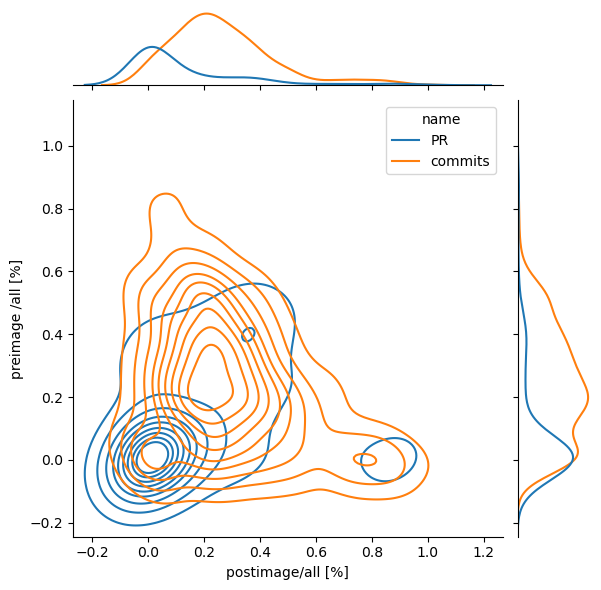

In [106]:
plot_ret_all({'PR (merged)': ret_fragments_pr, 'commits': commits})

## Read aggregated split PR sharings CSV (no plot_ret)

In [22]:
df_pr_split = pd.read_csv("../data/interim/pr_sharings_split_commit_df.csv")

In [23]:
df_pr_split.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number',
       'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions',
       'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'FirstCommitSha',
       'LastCommitSha', 'StateOpen', 'StateClosed', 'StateMerged',
       'NumberOfChatgptSharings', 'TotalNumberOfPrompts',
       'TotalTokensOfPrompts', 'TotalTokensOfAnswers', 'NumberOfConversations',
       'TotalNumberOfCodeBlocks', 'ModelGPT4', 'ModelGPT3.5', 'ModelOther',
       'Status404', 'title_count', 'body_count', 'comments.body_count',
       'reviews.body_count', 'CommitIdx', 'Sha'],
      dtype='object')

In [26]:
df_pr_split_group_by_url = df_pr_split.groupby(by='URL')

In [47]:
%time
df_pr_agg_sha = df_pr_split_group_by_url.agg(
    LastCommitIdx=pd.NamedAgg(column="CommitIdx", aggfunc="max"),
    CommitIdxIsIncreasing=pd.NamedAgg(column="CommitIdx", aggfunc=lambda col: col.is_monotonic_increasing),
    FirstSha=pd.NamedAgg(column="Sha", aggfunc="first"),
    LastSha=pd.NamedAgg(column="Sha", aggfunc="last"),
)

display(df_pr_agg_sha)
display(df_pr_agg_sha['CommitIdxIsIncreasing'].value_counts())

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


,LastCommitIdx,CommitIdxIsIncreasing,FirstSha,LastSha
URL,,,,
https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79,4,True,1c9e49a27057023ab5a1fd7e7f107d73938b34d9,f7f0ba5278ddf1d936fcd242165d97f4a295bb29
https://github.com/2Abendsegler/GClh/pull/2376,2,True,1585b67ab6a856c8d7b3f53c9b08617a2c662d0f,193c620d2e15f4e3cc59da22216a780b934b0242
https://github.com/4dn-dcic/foursight-core/pull/50,99,True,c4df9865ea585cffa8c57c401d10dadc6a7a1d44,fad3f4d4b2177c86f6d7e07b6f6cab9b3637cf74
https://github.com/AGnias47/AGnias47.github.io/pull/2,1,True,319ebd66922088c1240f694a98c4bb9aa860504f,9bba71d46c95d40a5ff7ef88b558fff0ce714e6a
https://github.com/ActivityWatch/aw-webui/pull/455,0,True,c93f546f2b9d2b97a6f340d4a1859f2aa80fd0a7,c93f546f2b9d2b97a6f340d4a1859f2aa80fd0a7
...,...,...,...,...
https://github.com/whatwg/whatwg.org/pull/427,1,True,26d19b578f9826122239a3dab041786720a31f9c,17fce19b86e696d7342d54ed13d576eca7770d77
https://github.com/xebia-functional/xef/pull/343,9,True,e0f2d1c2c4d66791fdfa1f1de3e5e5d486d4901e,4e1b5cfe8dcb8727c0c5b035d2d992e2803602bd
https://github.com/ykdojo/kaguya/pull/16,1,True,6663003bb5f85726225511986e2932b161c264c2,5d71d177ba8974a23738a7e3b191e0bdf663f042


CommitIdxIsIncreasing
True    267
Name: count, dtype: int64

In [48]:
example_url = 'https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79'
df_example_group = df_pr_split[df_pr_split['URL'] == example_url]
print(f"Examining group for URL = {example_url}")
print(f"'CommitIdx' column is monotonic increasing: {df_example_group['CommitIdx'].is_monotonic_increasing}")

df_example_group[['URL', 'CommitIdx', 'Sha']]

Examining group for URL = https://github.com/23-OSSCA-python-mysql-replication/python-mysql-replication/pull/79
'CommitIdx' column is monotonic increasing: True


,URL,CommitIdx,Sha
714,https://github.com/23-OSSCA-python-mysql-repli...,0,1c9e49a27057023ab5a1fd7e7f107d73938b34d9
715,https://github.com/23-OSSCA-python-mysql-repli...,1,3b8255763edf2b4d4d410ae105b0b435c1710041
716,https://github.com/23-OSSCA-python-mysql-repli...,2,9bcf867dc9518ee5e048a6518f6ff33d02cc8aae
717,https://github.com/23-OSSCA-python-mysql-repli...,3,7cc0e713b05fd82def255cc1b0220228ee2f3d27
718,https://github.com/23-OSSCA-python-mysql-repli...,4,f7f0ba5278ddf1d936fcd242165d97f4a295bb29


# `plot_ret_diff`

In [100]:
def plot_ret_diff(ret_dict, fname="histograms.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    df = pd.concat(dfs, keys=ret_dict.keys())

    df['diff'] = (df['PS'] - df['PR'])/df['all']
    #sns.histplot(df, x='diff', hue='name', multiple='dodge')
    sns.displot(df, x="diff", col="name",)
    plt.show()
    plt.savefig(fname)
    display(df)

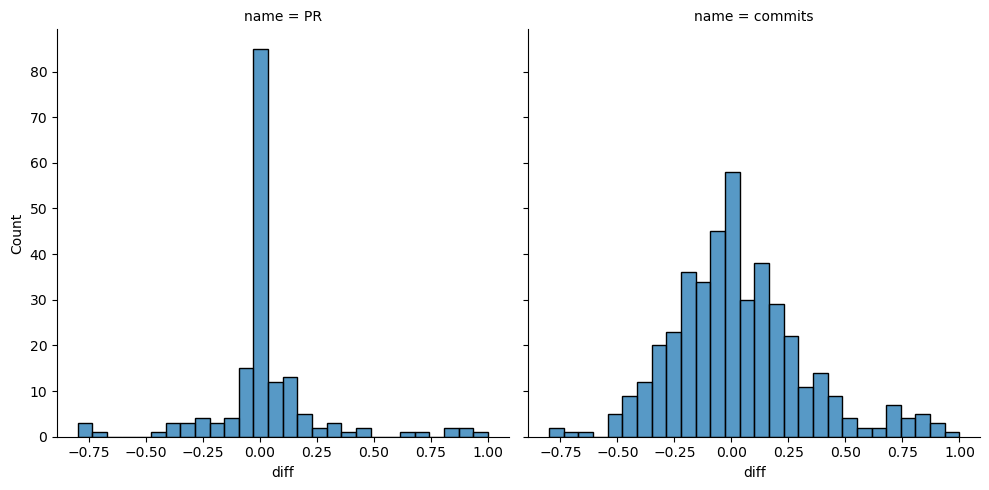

PR   PS   all  postimage/all [%]  preimage /all [%]     name  \
PR      0    710  274  1714           0.159860           0.414236       PR   
        1    823  632  1714           0.368728           0.480163       PR   
        2    696  349  1714           0.203617           0.406068       PR   
        3    615  636  1714           0.371062           0.358810       PR   
        4      0   20    58           0.344828           0.000000       PR   
...          ...  ...   ...                ...                ...      ...   
commits 424   13   26    76           0.342105           0.171053  commits   
        425   79   27   135           0.200000           0.585185  commits   
        426   20   88   141           0.624113           0.141844  commits   
        427    0    0    12           0.000000           0.000000  commits   
        428   84   86   207           0.415459           0.405797  commits   

                 diff  
PR      0   -0.254376  
        1   -0.111435  
        2   -0.202450  
        3    0.012252  
        4    0.344828  
...               ...  
commits 424  0.171053  
        425 -0.385185  
        426  0.482270  
        427  0.000000  
        428  0.009662  

[596 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

In [101]:
plot_ret_diff({'PR': ret_fragments_pr, 'commits': commits})

In [1]:
#pr_data

# Generating flow diagram

In [153]:
ret = []

for source in pr_data['Sources']:
    ret.append({'ds':'PR', 'state':source['State'], 'URL':source['URL'], 'count':1})

    

In [215]:
df_pr_state = pd.DataFrame(ret)#.groupby(['ds', 'state']).count().reset_index().to_csv(index=False))
display(df_pr_state['state'].unique())

display(df_pr_state)

array(['OPEN', 'CLOSED', 'MERGED'], dtype=object)

,ds,state,URL,count
0,PR,OPEN,https://github.com/FlorianWoelki/obsidian-symb...,1
1,PR,OPEN,https://github.com/asaskevich/govalidator/pull...,1
2,PR,OPEN,https://github.com/mlc-ai/web-stable-diffusion...,1
3,PR,OPEN,https://github.com/ActivityWatch/aw-webui/pull...,1
4,PR,OPEN,https://github.com/xebia-functional/xef/pull/343,1
...,...,...,...,...
209,PR,MERGED,https://github.com/openai/evals/pull/1083,1
210,PR,MERGED,https://github.com/VOICEVOX/voicevox_core/pull...,1
211,PR,MERGED,https://github.com/VOICEVOX/voicevox_core/pull...,1
212,PR,MERGED,https://github.com/VOICEVOX/voicevox/pull/1374,1


In [182]:
def merge_data(ret_dict, fname="histograms.svg"):
    dfs = []
    for r in ret_dict:
        dfs.append(ret_to_df(ret_dict[r], r))
    df = pd.concat(dfs, keys=ret_dict.keys())
    df['match / postimage [%]'] = df['PS'] / df['PS_all']

    return df
combined = merge_data({'PR': ret_fragments_pr, 'commits': commits})
combined = combined.reset_index()

In [183]:
combined

,level_0,level_1,id,PR,PS,all,PR_all,PS_all,postimage/all [%],preimage /all [%],name,match / postimage [%]
0,PR,0,https://github.com/open-learning-exchange/mypl...,710,274,1714,925,789,0.159860,0.414236,PR,0.347275
1,PR,1,https://github.com/open-learning-exchange/mypl...,823,632,1714,925,789,0.368728,0.480163,PR,0.801014
2,PR,2,https://github.com/open-learning-exchange/mypl...,696,349,1714,925,789,0.203617,0.406068,PR,0.442332
3,PR,3,https://github.com/open-learning-exchange/mypl...,615,636,1714,925,789,0.371062,0.358810,PR,0.806084
4,PR,4,https://github.com/Sambath-Kumar-M/Portfolio/p...,0,20,58,2,56,0.344828,0.000000,PR,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...
591,commits,424,https://github.com/hoshotakamoto/banzukesurfin...,13,26,76,34,42,0.342105,0.171053,commits,0.619048
592,commits,425,https://github.com/hoshotakamoto/banzukesurfin...,79,27,135,102,33,0.200000,0.585185,commits,0.818182
593,commits,426,https://github.com/hoshotakamoto/banzukesurfin...,20,88,141,35,106,0.624113,0.141844,commits,0.830189
594,commits,427,https://github.com/openai/evals/commit/771dce8...,0,0,12,0,12,0.000000,0.000000,commits,0.000000


In [188]:
combined['cat'] = pd.cut(combined['match / postimage [%]'], [-0.01,0.25,0.5, 0.75, 1.1])

In [166]:
print(combined.groupby(['name','cat']).count().reset_index()[['name', 'cat', 'PS']].to_csv(index=False))

name,cat,PS
PR,"(-0.01, 0.25]",108
PR,"(0.25, 0.5]",17
PR,"(0.5, 0.75]",10
PR,"(0.75, 1.1]",30
commits,"(-0.01, 0.25]",53
commits,"(0.25, 0.5]",52
commits,"(0.5, 0.75]",129
commits,"(0.75, 1.1]",193



In [270]:
df_all = combined.merge(df_pr_state, how='outer', left_on='id', right_on='URL')
df_all['state'].fillna("MERGED", inplace=True)
df_all['name'].fillna('PR', inplace=True)

df_all['lstate'] = df_all['state'].map(lambda x: 'NOT MERGED' if x != 'MERGED' else x)
df_all['lcat'] = df_all['cat'].astype(str)
df_all['lcat'] = df_all['lcat'].map(lambda x: "(-0.01, 0.25]" if x =="nan" else x)
df_all['lcat'] = df_all['name'].str[0] + " " + df_all['lcat']

df_all.groupby(['state']).count()

,level_0,level_1,id,PR,PS,all,PR_all,PS_all,postimage/all [%],preimage /all [%],name,match / postimage [%],cat,ds,URL,count,lstate,lcat
state,,,,,,,,,,,,,,,,,,
CLOSED,0,0,0,0,0,0,0,0,0,0,31,0,0,31,31,31,31,31
MERGED,593,593,593,593,593,593,593,593,591,591,610,589,589,181,181,181,610,610
OPEN,3,3,3,3,3,3,3,3,3,3,23,3,3,23,23,23,23,23


In [271]:

flow = df_all.groupby(['name','lcat', 'lstate']).count().reset_index()

In [272]:
#flow['lcat'] = flow['name'].str[0] + " " +flow['cat'].astype(str)

flow['C'] = flow[['id','count']].values.max(1)

In [273]:
print(flow[flow['C']>0][['name', 'lcat', 'C']].to_csv(index=False))

name,lcat,C
PR,"P (-0.01, 0.25]",124
PR,"P (-0.01, 0.25]",54
PR,"P (0.25, 0.5]",17
PR,"P (0.5, 0.75]",10
PR,"P (0.75, 1.1]",30
commits,"c (-0.01, 0.25]",55
commits,"c (0.25, 0.5]",52
commits,"c (0.5, 0.75]",129
commits,"c (0.75, 1.1]",193



In [274]:
print(flow[flow['C']>0][['lcat', 'lstate', 'C']].to_csv(index=False))

lcat,lstate,C
"P (-0.01, 0.25]",MERGED,124
"P (-0.01, 0.25]",NOT MERGED,54
"P (0.25, 0.5]",MERGED,17
"P (0.5, 0.75]",MERGED,10
"P (0.75, 1.1]",MERGED,30
"c (-0.01, 0.25]",MERGED,55
"c (0.25, 0.5]",MERGED,52
"c (0.5, 0.75]",MERGED,129
"c (0.75, 1.1]",MERGED,193

